# Problem Set 4 - Random Numbers

**Table of contents**<a id='toc0_'></a>    
- 1. [RNG Warm-up (Reproducibility Basics)](#toc1_)    
- 2. [Simulate the chain and estimate steady state unemployment (2-States)](#toc2_)    
  - 2.1. [Single Worker](#toc2_1_)    
  - 2.2. [Many Workers](#toc2_2_)    
- 3. [Spell lengths: Simulation vs. Theory](#toc3_)    
  - 3.1. [Simulation-based Spells](#toc3_1_)    
  - 3.2. [Theoretical Spells](#toc3_2_)    
- 4. [From hazards to a 2×2 transition matrix](#toc4_)    
- 5. [Power iteration (compute the stationary distribution)](#toc5_)    
  - 5.1. [Implementing the function](#toc5_1_)    
  - 5.2. [Implementing the function \& comparison to closed form](#toc5_2_)    
- 6. [3-state extension](#toc6_)    
  - 6.1. [Simulate a 3-state path](#toc6_1_)    
  - 6.2. [Build the 3-state transition matrix and compute stationary unemployment](#toc6_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Today: 

- 1 and 2 at 12:45

- 3 at 13:45

- 4 and 5 at 14:45

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. <a id='toc1_'></a>[RNG Warm-up (Reproducibility Basics)](#toc0_)

**Goal.** Create reproducible draws; understand *seed vs stream*.

- Create `rng = np.random.default_rng(2025)`.
- Draw 5 uniforms and 5 normals.
- Re-create the same sequence by constructing a **new** generator with the same seed.
- Show that **calling the same generator twice** advances the stream (different outputs).



In [2]:
# Starter (safe to run)
rng = np.random.default_rng(2025) # Seeded generator
u1 = rng.random(5)
z1 = rng.standard_normal(5)

# Task: Reproduce the first draws from the same seed
rng_same = np.random.default_rng(2025)
u2 = rng_same.random(5) # Uniform draws
z2 = rng_same.standard_normal(5) # Normal draws

# Stream progression (same generator again)
u_next = rng.random(5), rng_same.random(5)
z_next = rng.standard_normal(5), rng_same.standard_normal(5)

# Output results
print("u1:", u1)
print("u2 (match u1):", u2)
print("z1:", z1)
print("z2 (match z1):", z2)
print("u_next (different):", u_next)
print("z_next (different):", z_next)

# Here Jeppe uses assertions to verify correctness, if the assertions fail, an error will be raised
assert np.allclose(u1, u2) and np.allclose(z1, z2)
assert not np.allclose(u1, u_next) and not np.allclose(z1, z_next) # 

u1: [0.99445781 0.38200974 0.82714801 0.83725528 0.97580901]
u2 (match u1): [0.99445781 0.38200974 0.82714801 0.83725528 0.97580901]
z1: [ 0.7653914  -0.75970935  0.26699619  0.70178085  0.29212132]
z2 (match z1): [ 0.7653914  -0.75970935  0.26699619  0.70178085  0.29212132]
u_next (different): (array([0.38954302, 0.23021956, 0.16696115, 0.15343643, 0.9740917 ]), array([0.38954302, 0.23021956, 0.16696115, 0.15343643, 0.9740917 ]))
z_next (different): (array([-0.3924407 , -0.67731696,  2.93601077, -0.66462723,  1.25746344]), array([-0.3924407 , -0.67731696,  2.93601077, -0.66462723,  1.25746344]))


In [3]:
import runpy # runs A1.py as a script
_ = runpy.run_module("A1", run_name="__main__")  # no big dict printed


u1: [0.99445781 0.38200974 0.82714801 0.83725528 0.97580901]
u2 (match u1): [0.99445781 0.38200974 0.82714801 0.83725528 0.97580901]
z1: [ 0.7653914  -0.75970935  0.26699619  0.70178085  0.29212132]
z2 (match z1): [ 0.7653914  -0.75970935  0.26699619  0.70178085  0.29212132]
u_next (different): [0.38954302 0.23021956 0.16696115 0.15343643 0.9740917 ]
z_next (different): [-0.3924407  -0.67731696  2.93601077 -0.66462723  1.25746344]


## 2. <a id='toc2_'></a>[Simulate the chain and estimate steady state unemployment (2-States)](#toc0_)

**Goal.** Simulate the two-state Markov chain with transition matrix
$$
P=\begin{pmatrix}1-s & s\\ f & 1-f\end{pmatrix},
$$
produce a path of states $x_t\in\{0,1\}$ with $0=\text{E}$, $1=\text{U}$, and use the simulated time average to estimate the steady state unemployment share. Compare it to the theoretical stationary value from Exercise 3, $\pi_U^*=\frac{s}{s+f}$.

**Intuition**?
 Think of each period, a worker is in one state (e.g., **Employed** `E` or **Unemployed** `U`).  
 - A **transition probability** tells you how likely it is to go from one state to another next period (e.g., `P(E→U)` is the job‑separation rate, `P(U→E)` is the job‑finding rate).  
 - Over time, repeatedly applying the transition matrix generates a **Markov chain**. Simulating with random numbers just means:  
   1) For each individual and period, draw a uniform number `u ~ U[0,1]`.  
   2) Compare `u` to the relevant row of the transition matrix to decide the next state.  


### 2.1. <a id='toc2_1_'></a>[Single Worker](#toc0_)

**Goal.** Simulate a single worker who is hit by random shocks each period:

If Employed ($E$), a bad shock causes separation to Unemployment ($U$) with probability $s$.

If Unemployed ($U$), a good shock leads to job finding back to $E$ with probability $f$.
No formulas—just randomness that switches states.

**Task: Implement the following:**

1. Pick inputs: horizon $T$, separation probability $s$, job-finding probability $f$, initial state $s_0 \in {0,1}$ (encode $0=E$, $1=U$), and a seed.

2. For each period $t=0,\dots,T-1$, draw one uniform $\epsilon_t \sim \mathrm{U}[0,1]$ and apply:

  - If in $E$: set next state to $U$ if $\epsilon_t < s$, else stay in $E$.
  - If in $U$: set next state to $E$ if $\epsilon_t < f$, else stay in $U$.

3. Store the whole path of length $T+1$ and report the share of time in $U$ (the mean, since $U=1$).


**Hints**  

- Use $0=E$, $1=U$ so averages give unemployment directly.
- One fresh random draw per worker per period.
- Start small ($T=20$, $N=5$) to print and check; then scale up.
- Set a seed for reproducibility while debugging.

In [4]:
def simulate_worker_shocks(T, s, f, s0=0, seed=42):
    """
    States: 0=E, 1=U.
    - In E: separate to U with prob s
    - In U: find a job to E with prob f
    """
    
    # Set a random number generator with given seed
    rng = np.random.default_rng(seed) 
    
    # Generate states 
    states = np.empty(T + 1, dtype=np.int8)
    
    # Set first state to s0 (E or U)
    states[0] = s0
    
    # Generate all uniform draws at once
    uniforms = rng.random(T)  # one draw per period: u_t ~ U[0,1]

    for t in range(T):
        epsilon = uniforms[t]
        if states[t] == 0:                 # E today
            states[t+1] = 1 if (epsilon < s) else 0
        else:                              # U today
            states[t+1] = 0 if (epsilon < f) else 1

    return states, uniforms


T = 1_000
s = 0.02   # separation probability
f = 0.30   # job-finding probability
s0 = 0     # start employed
seed = 7

path, draws = simulate_worker_shocks(T, s, f, s0, seed)
print("First 10 shocks (uniforms):", np.round(draws[:10], 3))
print("First 10 states (0=E,1=U):", path[:11].tolist())   
print(f"Share of time in U (single worker): {path.mean():.3f}")

First 10 shocks (uniforms): [0.625 0.897 0.776 0.225 0.3   0.874 0.005 0.821 0.797 0.468]
First 10 states (0=E,1=U): [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Share of time in U (single worker): 0.052


In [5]:
# import runpy # runs A1.py as a script
# _ = runpy.run_module("A2_1", run_name="__main__")  # no big dict printed

### 2.2. <a id='toc2_2_'></a>[Many Workers](#toc0_)

- Next, simulate $N$ (e.g. 20,000) workers in parallel (one uniform per worker per period) and print the unemployment rate over time.

In [6]:
T = 10_000
N = 20_000
s = 0.02   # separation probability (E->U)
f = 0.30   # job-finding probability (U->E)
s0 = 0
seed = 7

def simulate_many_workers_shocks(T, N, s, f, s0=0, seed=42):
    rng = np.random.default_rng(seed)
    states = np.full((T + 1, N), s0, dtype=np.int8)
    U = rng.random((T, N))  # one draw per worker per period

    for t in range(T):
        in_E = (states[t] == 0)
        in_U = ~in_E

        # Start from "stay"
        states[t+1] = states[t]

        # E -> U on separation with prob s
        states[t+1, in_E] = np.where(U[t, in_E] < s, 1, 0)

        # U -> E on job finding with prob f
        states[t+1, in_U] = np.where(U[t, in_U] < f, 0, 1)

    u_rate = states.mean(axis=1)  # share unemployed each period
    return states, U, u_rate

N = 20_000
states, U, u_rate = simulate_many_workers_shocks(T, N, s, f, s0, seed)
print("First 10 unemployment rates:", np.round(u_rate[:10], 3))
print("Last 10 unemployment rates :", np.round(u_rate[-10:], 3))
print("Overall unemployment rate :", np.mean(u_rate))

First 10 unemployment rates: [0.    0.019 0.033 0.042 0.049 0.054 0.055 0.057 0.059 0.059]
Last 10 unemployment rates : [0.064 0.063 0.064 0.065 0.061 0.06  0.06  0.06  0.061 0.061]
Overall unemployment rate : 0.06251498350164984


In [7]:
# import runpy # runs A1.py as a script
# _ = runpy.run_module("A2_2", run_name="__main__")  # no big dict printed

## 3. <a id='toc3_'></a>[Spell lengths: Simulation vs. Theory](#toc0_)

**Goal.** From a simulated path of states ($0=E$, $1=U$), measure how long unemployment and employment spells last. Think of a spell as a streak: consecutive $U$’s is one unemployment spell; consecutive $E$’s is one employment spell. Then compare your measured averages to what you’d expect if shocks hit with constant per-period chances:
- Unemployment spells end when a good shock arrives (probability $f$ per period).
- Employment spells end when a bad shock arrives (probability $s$ per period).
So the “typical” spell length should be about $1/f$ for $U$ and $1/s$ for $E$.

### 3.1. <a id='toc3_1_'></a>[Simulation-based Spells](#toc0_)

**Tasks.** 

1. Get a path: simulate a state path of length $T+1$ using your $s$ and $f$ (or reuse your earlier simulation for the many worker case). Encode $0=E$ and $1=U$.

2. Identify spells as streaks:
        - An unemployment spell is a run of 1’s (e.g., ... 0 1 1 1 0 ... has one $U$ spell of length 3).
        - An employment spell is a run of 0’s.
        - We ignore right-censored final spells (a trailing run that does not end within the sample).

3. Measure lengths: scan the path and record the length of each run of 1’s (for $U$) and each run of 0’s (for $E$).        


In [8]:
def spell_lengths_step(series, value):
    """
    Return lengths of *completed* runs equal to `value` (0 or 1) in a 1-D binary array.
    By design, this ignores a trailing run at the end if it never finishes inside the sample
    (i.e., right-censored spell).
    """
    lengths = []   # will collect the lengths of each completed run
    run = 0        # current run length (number of consecutive elements == `value`)
    
    # Iterate through the series element by element
    for x in series:
        if x == value:
            # We are still in (or just entered) a run of the target value
            run += 1
        else:
            # We just hit a different value -> any ongoing run ends here
            if run > 0:
                lengths.append(run)  # record the completed run's length
                run = 0              # reset for the next potential run
    
    # Note: If the series ends while still in a run (run > 0), we IGNORE it on purpose.
    # That last spell is "right-censored" (didn't end within the observed window).
    
    return np.array(lengths, dtype=int)


def spell_lengths(states, value):
    """
    Collect spell lengths of `value` (0 or 1) across MANY workers.

    Parameters
    ----------
    states : ndarray, shape (T+1, N)
        Binary panel with time on rows and workers on columns (0=E, 1=U).
    value : int {0,1}
        Which state's spell lengths to measure.

    Returns
    -------
    np.ndarray (1D)
        A single concatenated array of all *completed* spell lengths
        across every worker (edge-censored last spells are ignored,
        as in `spell_lengths_1d`).
    """
    T1, N = states.shape          # T1 = T+1 rows (time), N columns (workers)
    all_len = []                  # will collect lengths from all workers

    # Loop over workers (each column is one worker's 1D state path)
    for j in range(N):
        # Compute runs for worker j using the 1D helper.
        # NOTE: make sure your helper is named `spell_lengths_1d`.
        lengths_j = spell_lengths_step(states[:, j], value)
        # Extend the master list with this worker's completed run lengths
        all_len.extend(lengths_j)

    # Return as a NumPy integer array
    return np.array(all_len, dtype=int)



###############
# Now let's apply it
###################

T = 1_000
N = 2_000
s = 0.02   # separation probability (E->U)
f = 0.30   # job-finding probability (U->E)
s0 = 0
seed = 7

states, Udraws, u_rate = simulate_many_workers_shocks(T, N, s, f, s0, seed)
print(f"Pooled unemployment (T×N)  : {states.mean():.3f}")  # across all obs

# spells
U_spells = spell_lengths(states, value=1)   # runs of unemployment
E_spells = spell_lengths(states, value=0)   # runs of employment

avg_U = U_spells.mean() if U_spells.size else np.nan
avg_E = E_spells.mean() if E_spells.size else np.nan

print(f"Unemployment spells: count={U_spells.size:,}, mean={avg_U:.3f}, theory~{1/f:.3f}")
print(f"Employment   spells: count={E_spells.size:,}, mean={avg_E:.3f}, theory~{1/s:.3f}")

Pooled unemployment (T×N)  : 0.062
Unemployment spells: count=37,353, mean=3.323, theory~3.333
Employment   spells: count=37,487, mean=47.608, theory~50.000


In [9]:
# import runpy # runs A3_1.py as a script
# _ = runpy.run_module("A3_1", run_name="__main__");  # no big dict printed


### 3.2. <a id='toc3_2_'></a>[Theoretical Spells](#toc0_)

1. Compare your simulation based spells to the geometric predictions, i.e.
- Unemployment spell length is geometric with mean $\mathbb{E}[T_U]=1/f$.
- Employment spell length is geometric with mean $\mathbb{E}[T_E]=1/s$.

2. Plot histograms of $U$- and $E$-spell lengths and overlay the geometric pmf with parameters $f$ and $s$.

Unemployment spells (U=1): count=37,353
  Sample mean length   : 3.323
  Theoretical 1/f      : 3.333

Employment spells (E=0): count=37,487
  Sample mean length   : 47.608
  Theoretical 1/s      : 50.000


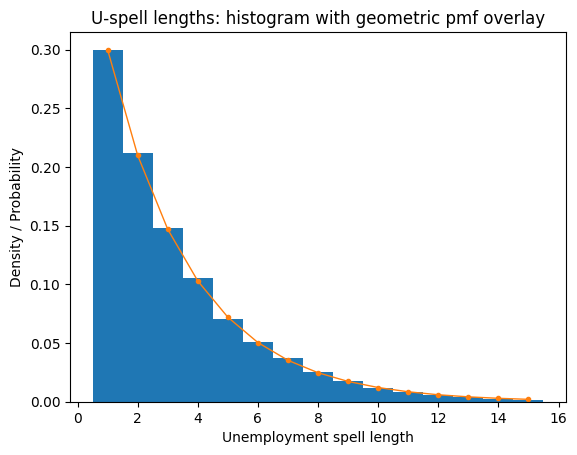

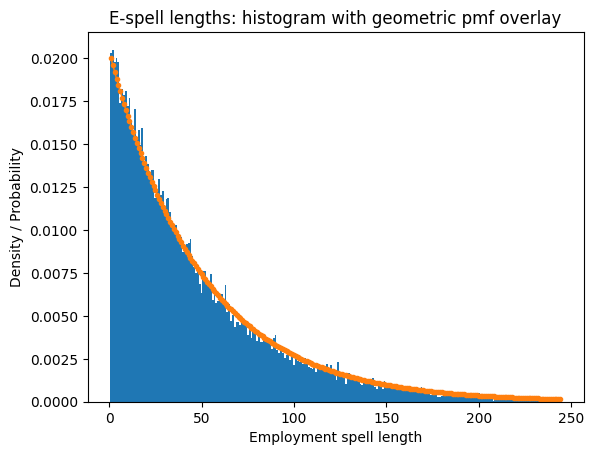

In [10]:

T = 1_000
N = 2_000
s = 0.02   # separation probability (E->U)
f = 0.30   # job-finding probability (U->E)
s0 = 0
seed = 7

states, Udraws, u_rate = simulate_many_workers_shocks(T, N, s, f, s0, seed)

# 1) Compute spell samples (runs of 1 = U, runs of 0 = E)
U_spells = spell_lengths(states, value=1)
E_spells = spell_lengths(states, value=0)

# Guard against empty arrays (shouldn't happen in long sims)
if U_spells.size == 0 or E_spells.size == 0:
    raise ValueError("No completed spells detected. Increase T or check simulation.")

# 2) Sample means vs geometric predictions
mean_U_sample = U_spells.mean()
mean_E_sample = E_spells.mean()
mean_U_theory = 1 / f
mean_E_theory = 1 / s

print(f"Unemployment spells (U=1): count={U_spells.size:,}")
print(f"  Sample mean length   : {mean_U_sample:.3f}")
print(f"  Theoretical 1/f      : {mean_U_theory:.3f}")
print()
print(f"Employment spells (E=0): count={E_spells.size:,}")
print(f"  Sample mean length   : {mean_E_sample:.3f}")
print(f"  Theoretical 1/s      : {mean_E_theory:.3f}")

# 3) Geometric pmf overlays
def geometric_pmf(k, p):
    """PMF for length k >= 1 with per-period exit prob p."""
    k = np.asarray(k)
    return (1 - p)**(k - 1) * p

# Choose x-ranges that cover most of the mass
kU_max = int(np.percentile(U_spells, 99.5))  # robust upper bound
kE_max = int(np.percentile(E_spells, 99.5))
kU = np.arange(1, max(2, kU_max + 1))
kE = np.arange(1, max(2, kE_max + 1))
pmf_U = geometric_pmf(kU, f)
pmf_E = geometric_pmf(kE, s)

# Controls
bin_w = 1.0      # bins (try 0.25 for even finer)
line_w = 1.0     # thickness of overlay line
ms = 3           # marker size

# 4) Plots: histogram (density) + pmf overlay
# U-spells
plt.figure()
plt.hist(U_spells, bins=np.arange(0.5, kU.max() + 1.5, bin_w), density=True)
plt.plot(kU, pmf_U, marker='o', linewidth=line_w, markersize=ms)
plt.xlabel("Unemployment spell length")
plt.ylabel("Density / Probability")
plt.title("U-spell lengths: histogram with geometric pmf overlay")
plt.show()

# E-spells
plt.figure()
plt.hist(E_spells, bins=np.arange(0.5, kE.max() + 1.5, bin_w), density=True)
plt.plot(kE, pmf_E, marker='o', linewidth=line_w, markersize=ms)
plt.xlabel("Employment spell length")
plt.ylabel("Density / Probability")
plt.title("E-spell lengths: histogram with geometric pmf overlay")
plt.show()

In [11]:
# import runpy # 
# _ = runpy.run_module("A3_2", run_name="__main__");  # no big dict printed

**Interpretation.** Discuss briefly the economic intuition of what you have computed and what the plots show.

## 4. <a id='toc4_'></a>[From hazards to a 2×2 transition matrix](#toc0_)

Let $s\in(0,1)$ be the probability to lose one's job (separation probability - transition from E to U) and $f\in(0,1)$ the job-finding probability (transition from U to E):
$$
P = \begin{pmatrix}
1-s & s\\\\
f & 1-f
\end{pmatrix}.
$$

**Matrix Interpretation**  
- States: `E=0` (employed), `U=1` (unemployed).  
- Rows = current state, columns = next state.  
  - From `E`: stay employed with prob `1−s`, move to `U` with prob `s`.  
  - From `U`: find a job with prob `f`, stay unemployed with prob `1−f`.  
- $P$ is **row-stochastic**: each row sums to 1 and all entries are in $[0,1]$.

**Your tasks**  
1. Implement `make_P_2state(s, f)` returning the matrix above.  
2. Validate that entries are in $[0,1]$ and each row sums to 1.


In [12]:
import numpy as np

def make_P_2state(s, f):
    """
    Return the 2x2 transition matrix for states 0=E (employed), 1=U (unemployed).
      s : separation probability  P(E -> U)
      f : job-finding probability P(U -> E)
    """
    assert 0.0 <= s <= 1.0 and 0.0 <= f <= 1.0, "Probabilities must be in [0,1]."
    P = np.array([[1.0 - s, s],
                  [f,       1.0 - f]], dtype=float)
    assert np.allclose(P.sum(axis=1), 1.0, atol=1e-12), "Rows must sum to 1."
    return P

In [13]:
# import runpy # 
# _ = runpy.run_module("A4", run_name="__main__");  # no big dict printed

# Print transition matrix P
P = make_P_2state(0.02, 0.30)
print("Transition matrix P:\n", P)

Transition matrix P:
 [[0.98 0.02]
 [0.3  0.7 ]]


## 5. <a id='toc5_'></a>[Power iteration (compute the stationary distribution)](#toc0_)

**Idea.** Think of $\mu^{(t)}$ as the share of people in each state at time $t$.
If everyone follows the same transition rules $P$, then next period’s shares are
$$
\mu^{(t+1)} \;=\; \mu^{(t)} P
$$
If you keep applying this update, the shares typically settle down to a fixed vector $\pi$ that doesn’t change when you multiply by $P$. That $\pi$ is the stationary distribution.


### 5.1. <a id='toc5_1_'></a>[Implementing the function](#toc0_)

**Task.** 

- Implement a function `stationary_power(P, tol=1e-12, maxit=1_000_000, mu0=None)` that returns `(mu, iters)` where:
  - `P` is an $n\times n$ **row-stochastic** matrix (each row sums to 1, entries in $[0,1]$).
  - `mu0` is an optional initial distribution $\mu^{(0)}$ (shape `(n,)`); if `None`, use the uniform vector.
  - Start from any probability vector $\mu^{(0)}$ (e.g., uniform).
  - Repeatedly update $\mu \leftarrow \mu P$.
  - Stop when $|\mu^{(t+1)}-\mu^{(t)}|_\infty < \texttt{tol}$ (the biggest absolute change in any entry is small).
  - Return the final $\mu$ (renormalized to sum to 1) and how many iterations it took.


In [14]:
import numpy as np

def stationary_power(P, tol=1e-12, maxit=1_000_000, mu0=None):
    """
    Power iteration for a row-stochastic transition matrix P.
    Returns (pi, iters) where pi is the stationary distribution (1D array).
    """
    P = np.asarray(P, dtype=float)
    n = P.shape[0]

    # Minimal sanity checks
    assert P.ndim == 2 and P.shape[0] == P.shape[1], "P must be square."
    assert np.allclose(P.sum(axis=1), 1.0, atol=1e-12), "Rows must sum to 1."
    assert np.all((P >= -1e-15) & (P <= 1 + 1e-15)), "Entries must be in [0,1]."

    # Start from uniform if none provided
    if mu0 is None:
        mu = np.full(n, 1.0/n)
    else:
        mu = np.asarray(mu0, dtype=float)
        mu = mu / mu.sum()

    # Iterate until the vector stops changing
    for it in range(1, maxit + 1):
        mu_next = mu @ P
        if np.max(np.abs(mu_next - mu)) < tol:
            mu = mu_next / mu_next.sum()  # normalize for safety
            return mu, it
        mu = mu_next

    # If not converged within maxit, return last iterate (normalized)
    mu = mu / mu.sum()
    return mu, maxit

# Test with 2-state P
P = make_P_2state(0.02, 0.30)
pi, iters = stationary_power(P)
print("Stationary distribution pi:", pi)
print("Converged in iterations  :", iters)

closed_form = 0.02/(0.02+0.30)

diff = np.abs(pi[1] - closed_form)
print("Difference from closed-form:", diff)

Stationary distribution pi: [0.9375 0.0625]
Converged in iterations  : 68
Difference from closed-form: 1.784766778811786e-12


In [15]:
# import runpy # 
# _ = runpy.run_module("A5_1", run_name="__main__");  # no big dict printed

### 5.2. <a id='toc5_2_'></a>[Implementing the function \& comparison to closed form](#toc0_)

**Task.** 

1. **Apply the function.** Use your function `stationary_power(P, tol, maxit, mu0)` to obtain
   $$
   (\pi,\ \texttt{iters}), \qquad \pi=(\pi_E,\pi_U), \quad \pi=\pi P,\quad \pi_E+\pi_U=1.
   $$
   Report \(\pi_U\) (the stationary unemployment rate) and the iteration count.

2. **Closed-form benchmark.** Compute the theoretical steady state implied by the hazards:
   $$
   \pi_U^{\text{cf}}=\frac{s}{s+f}
   $$

3. **Compare.** Verify numerically that
   $$
   \bigl|\pi_U - \pi_U^{\text{cf}}\bigr| \;<\; 10^{-10}
   $$


In [16]:
# import runpy # 
# _ = runpy.run_module("A5_2", run_name="__main__");  # no big dict printed

## 6. <a id='toc6_'></a>[3-state extension](#toc0_)

**Setup.** States are encoded as **`E=0`** (employed), **`U=1`** (short-term unemployed), **`L=2`** (long-term unemployed).

### 6.1. <a id='toc6_1_'></a>[Simulate a 3-state path](#toc0_)

**Goal.** Simulate a panel of workers over time where each worker gets one random shock per period and moves according to the current row of a $3\times3$ transition matrix.

**Inputs.**
Horizon $T$, workers $N$, probabilities per period $s$ ($E\!\to\!U$), $f_s$ ($U\!\to\!E$), $\ell$ ($U\!\to\!L$), $f_\ell$ ($L\!\to\!E$), and initial states. Require $s,f_s,\ell,f_\ell\in[0,1]$ and $f_s+\ell\le1$. 

**Use the following parameter values for your simulation:**
- T   = 10_000   # horizon
- N   = 20_000   # number of workers
- s   = 0.02     # E -> U separation probability
- f_s = 0.30     # U -> E job-finding probability
- ell = 0.10     # U -> L progression probability
- f_l = 0.20     # L -> E job-finding probability

**Dynamics (each period, each worker).**
- If in $E$: with prob $s$ go to $U$, else stay $E$.
- If in $U$: with prob $f_s$ go to $E$; else if $u<f_s+\ell$ go to $L$; else stay $U$.
- If in $L$: with prob $f_\ell$ go to $E$, else stay $L$.

**Task.**
1) Extend the function `simulate_many_workers_shocks` from above to `simulate_many_workers_shocks_3state`.
2) Build `states` of shape $(T+1,N)$ with entries in $\{0,1,2\}$ and set `states[0,:]`.
3) Print the first and last 10 unemployment rates; the time-average; and the pooled unemployment (T $\times$ N).

**Hints.**
- Use cumulative thresholds: for $U$, compare $u$ to $f_s$ and $f_s+\ell$.
- Vectorize with boolean masks for current $E/U/L$; or start with simple loops.
- Set a seed for reproducibility.


In [17]:
import numpy as np

def simulate_many_workers_shocks_3state(T, N, s, f_s, ell, f_l, s0=0, seed=42):
    """
    Vectorized many-workers simulation for a 3-state model.
    Returns states (T+1,N), the uniform draws U (T,N), and u_rate (unemp. share each t).
    """
    assert 0 <= s <= 1 and 0 <= f_s <= 1 and 0 <= ell <= 1 and 0 <= f_l <= 1
    assert f_s + ell <= 1, "In U: stay prob = 1 - f_s - ell must be >= 0"

    rng = np.random.default_rng(seed)
    states = np.full((T + 1, N), s0, dtype=np.int8)   # 0=E, 1=U, 2=L
    U = rng.random((T, N))                            # one draw per worker per period

    for t in range(T):
        cur = states[t]
        nxt = cur.copy()          # start from "stay"

        inE = (cur == 0)
        inU = (cur == 1)
        inL = (cur == 2)

        # E: with prob s -> U; else stay E
        rE = U[t, inE]
        nxt[inE] = np.where(rE < s, 1, 0)

        # U: with prob f_s -> E; else if < f_s+ell -> L; else stay U
        rU = U[t, inU]
        idxU = np.where(inU)[0]
        toE = rU < f_s
        toL = (rU >= f_s) & (rU < f_s + ell)
        nxt[idxU[toE]] = 0
        nxt[idxU[toL]] = 2
        # remaining U stay in U

        # L: with prob f_l -> E; else stay L
        rL = U[t, inL]
        idxL = np.where(inL)[0]
        toE_L = rL < f_l
        nxt[idxL[toE_L]] = 0

        states[t + 1] = nxt

    # unemployment share (U or L)
    u_rate = (states != 0).mean(axis=1)
    return states, U, u_rate

T = 10_000
N = 20_000
s   = 0.02   # E->U
f_s = 0.30   # U->E
ell = 0.10   # U->L
f_l = 0.20   # L->E
s0  = 0
seed = 7

states, Udraws, u_rate = simulate_many_workers_shocks_3state(T, N, s, f_s, ell, f_l, s0, seed)

print("First 10 unemployment rates:", np.round(u_rate[:10], 3))
print("Last 10 unemployment rates :", np.round(u_rate[-10:], 3))
print(f"Time-avg unemployment      : {u_rate.mean():.3f}")
print(f"Pooled unemployment (T×N)  : {(states != 0).mean():.3f}")

First 10 unemployment rates: [0.    0.019 0.033 0.042 0.05  0.055 0.056 0.06  0.062 0.063]
Last 10 unemployment rates : [0.071 0.069 0.072 0.073 0.069 0.067 0.067 0.067 0.068 0.069]
Time-avg unemployment      : 0.070
Pooled unemployment (T×N)  : 0.070


In [18]:
import runpy # 
_ = runpy.run_module("A6_1", run_name="__main__");  # no big dict printed

First 10 unemployment rates: [0.    0.019 0.033 0.042 0.05  0.055 0.056 0.06  0.062 0.063]
Last 10 unemployment rates : [0.071 0.069 0.072 0.073 0.069 0.067 0.067 0.067 0.068 0.069]
Time-avg unemployment      : 0.070
Pooled unemployment (T×N)  : 0.070


### 6.2. <a id='toc6_2_'></a>[Build the 3-state transition matrix and compute stationary unemployment](#toc0_)

**1) Construct $P$ (rows = current state, cols = next state).**
$$
P \equiv
\begin{bmatrix}
1-s & s & 0 \\
f_s & 1-f_s-\ell & \ell \\
f_\ell & 0 & 1-f_\ell
\end{bmatrix}
$$
Check: each row sums to $1$ and entries are in $[0,1]$.

**2) Compute the stationary distribution $\pi=(\pi_0,\pi_1,\pi_2)$.**
Interpretation: $\pi_0=\Pr(E)$, $\pi_1=\Pr(U)$, $\pi_2=\Pr(L)$ in the long run.
- start $\pi^{(0)}$, iterate $\pi^{(t+1)}=\pi^{(t)}P$ until convergence.

**3) Compute the steady state unemployment rate.**
$$ 
u^\ast = \pi_1 + \pi_2 \quad\text{(steady state share in $U$ or $L$).}
$$ 


In [19]:
import numpy as np

# --- Step 1: 3-state transition matrix ---
def make_P_3state(s, f_s, ell, f_l):
    """
    Return the 3x3 transition matrix for states 0=E, 1=U, 2=L.
      s   : P(E->U)
      f_s : P(U->E)
      ell : P(U->L)
      f_l : P(L->E)
    """
    # sanity checks
    for p in (s, f_s, ell, f_l):
        assert 0.0 <= p <= 1.0, "Probabilities must be in [0,1]."
    assert f_s + ell <= 1.0, "In U: stay prob = 1 - f_s - ell must be >= 0."

    P = np.array([
        [1.0 - s,   s,             0.0],
        [f_s,       1.0 - f_s - ell, ell],
        [f_l,       0.0,           1.0 - f_l]
    ], dtype=float)

    # row-stochastic checks
    assert np.allclose(P.sum(axis=1), 1.0, atol=1e-12), "Rows must sum to 1."
    assert np.all((P >= -1e-15) & (P <= 1 + 1e-15)), "Entries must be in [0,1]."
    return P

# --- Step 2: stationary distribution via power iteration (from earlier) ---
def stationary_power(P, tol=1e-12, maxit=1_000_000, mu0=None):
    """
    Power iteration for a row-stochastic transition matrix P.
    Returns (pi, iters) where pi is the stationary distribution (1D array).
    """
    P = np.asarray(P, dtype=float)
    n = P.shape[0]
    assert P.ndim == 2 and P.shape[0] == P.shape[1], "P must be square."
    assert np.allclose(P.sum(axis=1), 1.0, atol=1e-12), "Rows must sum to 1."
    assert np.all((P >= -1e-15) & (P <= 1 + 1e-15)), "Entries must be in [0,1]."

    mu = np.full(n, 1.0/n) if mu0 is None else np.asarray(mu0, dtype=float)
    mu = mu / mu.sum()

    for it in range(1, maxit + 1):
        mu_next = mu @ P
        if np.max(np.abs(mu_next - mu)) < tol:
            mu = mu_next / mu_next.sum()
            return mu, it
        mu = mu_next

    return mu / mu.sum(), maxit

# --- Parameters ---
s   = 0.02     # E -> U
f_s = 0.30     # U -> E
ell = 0.10     # U -> L
f_l = 0.20     # L -> E

# Build P and compute stationary distribution
P = make_P_3state(s, f_s, ell, f_l)
pi, iters = stationary_power(P, tol=1e-14)

u_star = pi[1] + pi[2]   # Step 3: steady-state unemployment

print("Transition matrix P:\n", P)
print("Stationary distribution pi (E, U, L):", np.round(pi, 6))
print("Steady-state unemployment u* (= pi_U + pi_L):", round(float(u_star), 6))
print("Converged in iterations:", iters)

Transition matrix P:
 [[0.98 0.02 0.  ]
 [0.3  0.6  0.1 ]
 [0.2  0.   0.8 ]]
Stationary distribution pi (E, U, L): [0.930233 0.046512 0.023256]
Steady-state unemployment u* (= pi_U + pi_L): 0.069767
Converged in iterations: 129


In [20]:
import runpy # 
_ = runpy.run_module("A6_2", run_name="__main__");  # no big dict printed

Transition matrix P:
 [[0.98 0.02 0.  ]
 [0.3  0.6  0.1 ]
 [0.2  0.   0.8 ]]
Stationary distribution pi (E, U, L): [0.930233 0.046512 0.023256]
Steady-state unemployment u* (= pi_U + pi_L): 0.069767
Converged in iterations: 129
